# sequence prediction sandbox


In [1]:
import torch
from torch import nn

from collections import defaultdict
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
def kmers(k):
    return [''.join(x) for x in product(['A','C','G','T'], repeat=k)]

def count_kmers_in_seq(seq, mers):
    '''
    For a given sequence and kmer set, return the count
    '''
    return [seq.count(mer) for mer in mers]

seqs8 = kmers(8)
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [3]:
# if you want to down select
seqs8_200 = u.downselect_list(seqs8,200)

In [4]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}

def mode0(seq):
    '''Ignore motifs, just return average score'''
    return np.mean([score_dict[base] for base in seq])

def mode1(seq):
    '''Return average score, TAT gets +10, GCG gets -10'''
    score = np.mean([score_dict[base] for base in seq])
    if 'TAT' in seq:
        score += 10
    if 'GCG' in seq:
        score -= 10
        
    return score

def mode2(seq):
    '''Return average score, GCG gets +10, TAT gets -10'''
    score = np.mean([score_dict[base] for base in seq])
    if 'GCG' in seq:
        score += 10
    if 'TAT' in seq:
        score -= 10
        
    return score
    

modes = {
    0: mode0,
    1: mode1,
    2: mode2,
}
                  
def score_seqs_multi(seqs, mode_list):
    '''
    Mode 0: ignore motifs
    Mode 1: TAT is high, GCG is low
    Mode 2: GCG is high, TAT is low
    '''
    data = []
    for seq in seqs:
        scores = []
        for mode in mode_list:
            score = modes[mode](seq) # call the mode function
            scores.append(score)
        data.append([seq]+scores)
    
    cols = ['seq'] + [f"mode{m}" for m in mode_list]
        
    df = pd.DataFrame(data, columns=cols)
    return df


In [5]:
multi_df = score_seqs_multi(seqs8,[0,1,2])

In [6]:
multi_df[multi_df['seq']=='AATATAAA']

,seq,mode0,mode1,mode2
3264,AATATAAA,17.75,27.75,7.75


In [7]:
multi_df[multi_df['seq']=='AAGCGATA']

,seq,mode0,mode1,mode2
2444,AAGCGATA,17.0,7.0,27.0


In [8]:
multi_df.head()

,seq,mode0,mode1,mode2
0,AAAAAAAA,20.000,20.000,20.000
1,AAAAAAAC,19.625,19.625,19.625
2,AAAAAAAG,19.250,19.250,19.250
3,AAAAAAAT,18.875,18.875,18.875
4,AAAAAACA,19.625,19.625,19.625


### Define some Custom Dataset/Dataloader functions

In [9]:
from torch.utils.data import TensorDataset,DataLoader,Dataset
import random
random.seed(7)

In [10]:
class MultiTaskDatasetOHE(Dataset):
    '''
    Multi-task for one-hot-encoded sequences
    '''
    def __init__(self,df):
        self.seqs = list(df['seq'])
        self.seq_len = len(self.seqs[0])
    
        self.label0 = list(df['mode0'])
        self.label1 = list(df['mode1'])
        self.label2 = list(df['mode2'])
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        seq = torch.tensor(u.one_hot_encode(self.seqs[idx]))
        
        label0 = torch.tensor(float(self.label0[idx]))
        label1 = torch.tensor(float(self.label1[idx]))
        label2 = torch.tensor(float(self.label2[idx]))
        
        return seq, (label0, label1, label2)

    
class MultiTaskDatasetKmer(Dataset):
    '''
    Multi-task for k-mer frequencies
    '''
    def __init__(self,df,k):
        self.seqs = list(df['seq'])
        self.seq_len = len(self.seqs[0])
        self.kmers = kmers(k)
    
        self.label0 = list(df['mode0'])
        self.label1 = list(df['mode1'])
        self.label2 = list(df['mode2'])
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        kmer_vec = torch.tensor(count_kmers_in_seq(self.seqs[idx],self.kmers))
        
        label0 = torch.tensor(float(self.label0[idx]))
        label1 = torch.tensor(float(self.label1[idx]))
        label2 = torch.tensor(float(self.label2[idx]))
        
        return kmer_vec, (label0, label1, label2)

In [11]:
def quick_load_and_split_input(df, split_frac=0.8, verbose=False):
    '''
    Given a df, randomly split between
    train and test. Not a formal train/test split, just a quick n dirty version.
    '''

    # train test split
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split df and convert to tensors
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df, test_df


class DatasetSpec():
    '''
    Quick access class for speciying the type of dataset to build
    '''
    def __init__(self,ds_type,k=None):
        self.name = ds_type
        self.k = k
        
        self.id = self.name if not k else f"{self.name}_{k}"
    

def build_dataloaders(df,ds_types,batch_size=32):
    '''
    Given an input dataframe and a list of dataset types, assemble them into 
    a dictionary of DataLoaders
    '''
    # train test split
    train_df, test_df = quick_load_and_split_input(df)
    
    dls = {} # collect data loaders
    
    # figure out which DataSetTypes needed
    for ds_type in ds_types:
        # Kmer data set
        if ds_type.name == 'multi_kmer':
            if not ds_type.k:
                raise ValueError(f"To use multi_kmer Dataset, you must specify an integer value for k in DatasetSpec")
            assert(type(ds_type.k) == int)

            train_ds = MultiTaskDatasetKmer(train_df,ds_type.k)
            test_ds = MultiTaskDatasetKmer(test_df,ds_type.k)

        # One-hot encoded dataset
        elif ds_type.name == 'multi_ohe':
            train_ds = MultiTaskDatasetOHE(train_df)
            test_ds = MultiTaskDatasetOHE(test_df)

        # unknown datatype?
        else:
            raise ValueError(f"Unknown Dataset Type {ds_type}.")
        
        # Put DataSets into DataLoaders
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
        dls[ds_type.id] = (train_dl,test_dl)
    
    return train_df,test_df, dls

In [13]:
dataset_types = [
    DatasetSpec('multi_ohe'),
    DatasetSpec('multi_kmer',k=1),
    DatasetSpec('multi_kmer',k=3),
    #DatasetSpec('multi_kmer',k=6),
]

train_df, test_df, dls = build_dataloaders(multi_df,dataset_types)
dls

{'multi_ohe': (<torch.utils.data.dataloader.DataLoader at 0x7f9facdcb640>,
  <torch.utils.data.dataloader.DataLoader at 0x7f9facdcbfa0>),
 'multi_kmer_1': (<torch.utils.data.dataloader.DataLoader at 0x7f9facdcbac0>,
  <torch.utils.data.dataloader.DataLoader at 0x7f9facdcb160>),
 'multi_kmer_3': (<torch.utils.data.dataloader.DataLoader at 0x7f9facdcbd60>,
  <torch.utils.data.dataloader.DataLoader at 0x7f9facd9f1f0>)}

In [14]:
dls['multi_kmer_1'][0].dataset.kmers

['A', 'C', 'G', 'T']

### Define Loss and Fit functions

In [15]:
def get_loss_for_condition_average(train_df, test_df, conditions, loss_func):
    '''
    For any sequence, just predict the average of all the training sequences
    scores in that condition. (Basically a column average of that condition in 
    the training set). Since it's not learning over time, this will just be 
    a flat score. Calculate the loss between the actual test set target values
    and this average value. Use this loss as a reference for other models' losses
    over time.
    '''
    # get average score by condition from train df
    losses = []
    for cond in conditions:
        # average from train df
        pred = np.mean(train_df[cond].values)
        
        # target vec from test df
        target_vec = torch.tensor(test_df[cond].values)
        pred_vec = torch.tensor([pred for x in target_vec])
        
        cond_loss = loss_func(pred_vec, target_vec)
        losses.append(cond_loss)
    
    # combine losses from each condition
    loss = torch.mean(torch.stack(losses))
    
    
    return loss.item()
    

In [16]:
# just get loss from predicting average (should be not good cuz not learning anything)
conds = ['mode0','mode1','mode2']
loss_func = torch.nn.MSELoss()
ave_pd_loss = get_loss_for_condition_average(train_df, test_df, conds, loss_func)
ave_pd_loss

12.587688586285863

In [17]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    #print("in Loss Batch...")
    obj0_target = yb[0].unsqueeze(1).float()
    obj1_target = yb[1].unsqueeze(1).float()
    obj2_target = yb[2].unsqueeze(1).float()
    # need unsqueeze otherwise dimension mismatch? [32] vs [32,1]

    
    #loss = loss_func(model(xb.float()), yb.float())
    # yb is a list of tensors... what should it be?
    # how to adapt loss for multi-task?
    #print("yb[0]:", yb[0])
    
    # try looping through ybs?
    res = model(xb.float()) # get predictions? returns list
    
    loss_obj0 = loss_func(res[0], obj0_target)
    loss_obj1 = loss_func(res[1], obj1_target)
    loss_obj2 = loss_func(res[2], obj2_target)
    
    #loss = sum([loss_obj0, loss_obj1, loss_obj2])/3
    loss = torch.mean(torch.stack([loss_obj0, loss_obj1, loss_obj2]))
#     print("what is 'loss'?:")
#     print("0:",loss_obj0)
#     print("1:",loss_obj1)
#     print("2:",loss_obj2)
#     print("all:",loss)
#     print("*****")

    if opt is not None:
        opt.zero_grad() # order? should this be first? last?
        loss.backward()
        opt.step()
        

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, test_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        print('Epoch:',epoch)
        #print("TRAIN")
        model.train()
        ts = []
        ns = []
        # collect train loss; provide opt so backpropo happens
        for xb, yb in train_dl:
            t, n = loss_batch(model, loss_func, xb, yb, opt)
            ts.append(t)
            ns.append(n)
        train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
        train_losses.append(train_loss)
        
        #print("EVAL")
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                # loop through test batches
                # returns loss calc for test set batch size
                # unzips into two lists
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
                # Note: no opt provided, backprop won't happen
            )
        # Gets average MSE loss across all batches (may be of diff sizes, hence the multiply)
        #print("losses", losses)
        #print("nums", nums)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

## Define model types

In [18]:
class DNA_Linear_Multi(nn.Module):
    def __init__(self,seq_len,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin_share = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True)
        )
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(h2_size,1)
        self.obj1  = nn.Linear(h2_size,1)
        self.obj2  = nn.Linear(h2_size,1)
        
        
    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin_share(xb)
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        
        return (out0, out1, out2)

class Kmer_Linear_Multi(nn.Module):
    def __init__(self,num_kmers,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin_share = nn.Sequential(
            nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True)
        )
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(h2_size,1)
        self.obj1  = nn.Linear(h2_size,1)
        self.obj2  = nn.Linear(h2_size,1)
        
        
    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin_share(xb)
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        
        return (out0, out1, out2)
    
    
DATASET_TYPES = {
    'multi_ohe':MultiTaskDatasetOHE,
    'multi_kmer':MultiTaskDatasetKmer,
}
    

## try linear kmer model

Epoch: 0
0 0.23406082770065598
Epoch: 1
1 0.2150304477899439
Epoch: 2
2 0.22591638963397845
Epoch: 3
3 0.2931310943906759
Epoch: 4
4 0.19292863667793378
Epoch: 5
5 0.3013045839558369
Epoch: 6
6 0.19218416422432721
Epoch: 7
7 0.23832412105454953
Epoch: 8
8 0.19398583822363863
Epoch: 9
9 0.21286210715134113


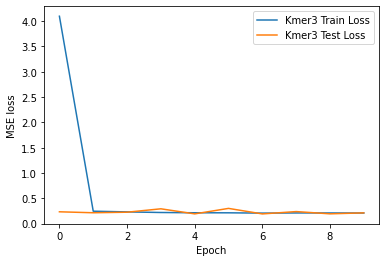

In [24]:
h1 = 10
h2 = 10
train_dl,test_dl = dls['multi_kmer_3']

num_kmers = len(train_dl.dataset.kmers)

kmer_lin_model = Kmer_Linear_Multi(num_kmers, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(kmer_lin_model.parameters(), lr=0.01) 

epochs = 10
train_losses, val_losses = fit(epochs, kmer_lin_model, loss_func, optimizer, train_dl, test_dl)

kmer_lin_data_label = list(zip([train_losses,val_losses], ['Kmer3 Train Loss','Kmer3 Test Loss']))
u.quick_loss_plot(kmer_lin_data_label)

In [20]:
# check out model??
kmer_lin_model

Kmer_Linear_Multi(
  (lin_share): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU(inplace=True)
  )
  (obj0): Linear(in_features=10, out_features=1, bias=True)
  (obj1): Linear(in_features=10, out_features=1, bias=True)
  (obj2): Linear(in_features=10, out_features=1, bias=True)
)

In [21]:
lin = kmer_lin_model.lin_share[0]
w = lin.weight
x = sum(w)

xdf = pd.DataFrame(list(zip(train_dl.dataset.kmers, [y.item() for y in x])), columns=['mer','w'])
xdf.sort_values('w').tail(30)

,mer,w
48,TAA,0.091685
59,TGT,0.104605
12,ATA,0.117579
36,GCA,0.136649
47,GTT,0.142590
30,CTG,0.143182
32,GAA,0.144166
31,CTT,0.146641
27,CGT,0.147011
41,GGC,0.160700


### k=1

Epoch: 0
0 8.740882154568906
Epoch: 1
1 8.617391567678396
Epoch: 2
2 8.774970091149543
Epoch: 3
3 8.667474755143697
Epoch: 4
4 8.771231905949127
Epoch: 5
5 8.593559624110558
Epoch: 6
6 8.683506989355381
Epoch: 7
7 8.553341018815283
Epoch: 8
8 8.574869461164338
Epoch: 9
9 8.633514966839583


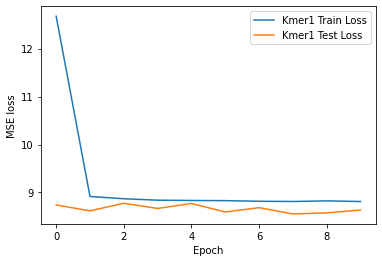

In [22]:
train_dl,test_dl = dls['multi_kmer_1']

num_kmers = len(train_dl.dataset.kmers)

kmer1_lin_model = Kmer_Linear_Multi(num_kmers, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(kmer1_lin_model.parameters(), lr=0.01) 

epochs = 10
train_losses, val_losses = fit(epochs, kmer1_lin_model, loss_func, optimizer, train_dl, test_dl)

kmer1_lin_data_label = list(zip([train_losses,val_losses], ['Kmer1 Train Loss','Kmer1 Test Loss']))
u.quick_loss_plot(kmer1_lin_data_label)

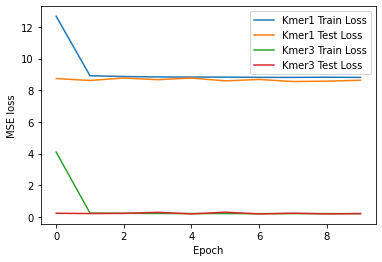

In [25]:
u.quick_loss_plot(kmer1_lin_data_label+kmer_lin_data_label)

### k=6

Epoch: 0
0 12.871628274414137
Epoch: 1
1 12.634990466888773
Epoch: 2
2 12.419810066071815
Epoch: 3
3 12.184372272730092
Epoch: 4
4 12.000531635016685
Epoch: 5
5 11.884442659278523
Epoch: 6
6 11.827062289599132
Epoch: 7
7 11.801910747723642
Epoch: 8
8 11.771343021811893
Epoch: 9
9 11.725116459087223


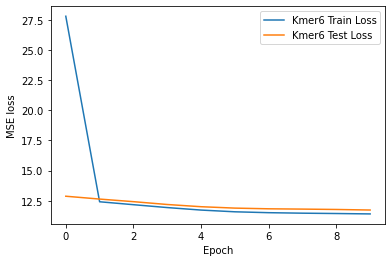

In [22]:
train_dl,test_dl = dls['multi_kmer_6']

num_kmers = len(train_dl.dataset.kmers)

kmer6_lin_model = Kmer_Linear_Multi(num_kmers, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(kmer6_lin_model.parameters(), lr=0.001) 

epochs = 10
train_losses, val_losses = fit(epochs, kmer6_lin_model, loss_func, optimizer, train_dl, test_dl)

kmer6_lin_data_label = list(zip([train_losses,val_losses], ['Kmer6 Train Loss','Kmer6 Test Loss']))
u.quick_loss_plot(kmer6_lin_data_label)

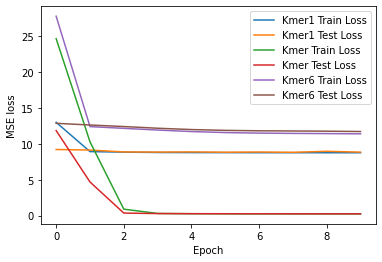

In [23]:
u.quick_loss_plot(kmer1_lin_data_label+kmer_lin_data_label+kmer6_lin_data_label)

## try linear OHE model

In [26]:
h1 = 10
h2 = 10
seq_len = len(train_df['seq'][0])
seq_len

8

Epoch: 0
0 9.217712387792723
Epoch: 1
1 10.224764277595261
Epoch: 2
2 10.9390696486868
Epoch: 3
3 4.843363289721026
Epoch: 4
4 4.253174850480164
Epoch: 5
5 3.385961676793452
Epoch: 6
6 2.7362870829186137
Epoch: 7
7 3.3016268751553586
Epoch: 8
8 3.4465065646324358
Epoch: 9
9 2.889716946791322


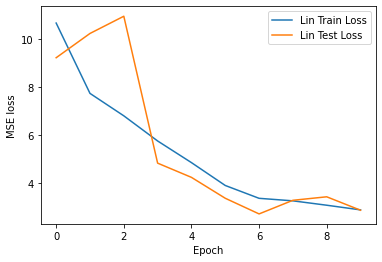

In [27]:
multi_lin_model = DNA_Linear_Multi(seq_len, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_lin_model.parameters(), lr=0.01) 

epochs = 10
train_dl,test_dl = dls['multi_ohe']
train_losses, val_losses = fit(epochs, multi_lin_model, loss_func, optimizer, train_dl, test_dl)

multi_lin_data_label = list(zip([train_losses,val_losses], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(multi_lin_data_label)

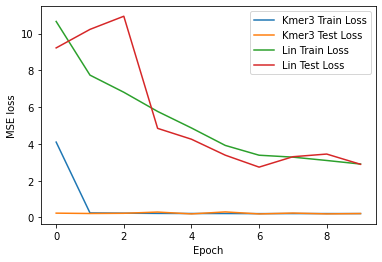

In [28]:
u.quick_loss_plot(kmer_lin_data_label + multi_lin_data_label)

In [29]:
def quick_seq_pred_multi(model, seqs,dss,oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        if dss.name == "multi_ohe":
            s = torch.tensor(u.one_hot_encode(dna))
        elif dss.name == "multi_kmer":
            s = torch.tensor(count_kmers_in_seq(dna,kmers(dss.k)))
        else:
            raise ValueError(f"Unknown DataSetSpec Type {dss.name}. Currently just [multi_ohe,multi_kmer]")
        pred = [x.item() for x in model(s.float())]
        actual = oracle[dna]
        diff = [actual[i]-pred[i] for i in range(len(pred))]
        print(f"{dna}: \n \tpred:{pred[0]:.3f} act:{actual[0]:.3f} ({diff[0]:.3f}) \n\tpred:{pred[1]:.3f} act:{actual[1]:.3f} ({diff[1]:.3f}) \n\tpred:{pred[2]:.3f} act:{actual[2]:.3f} ({diff[2]:.3f})")
        

def quick_test8(model,dss,oracle):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        quick_seq_pred_multi(model, seqs,dss,oracle)
        print()

In [31]:
multi_8mer_oracle = dict([(x,[a,b,c]) for (x,a,b,c) in multi_df[['seq','mode0','mode1','mode2']].values])

In [32]:
multi_8mer_oracle['AAAAAAAA']

[20.0, 20.0, 20.0]

In [33]:
dataset_types

In [34]:
quick_test8(multi_lin_model,DatasetSpec('multi_ohe'),multi_8mer_oracle)

AAAAAAAA: 
 	pred:19.438 act:20.000 (0.562) 
	pred:21.165 act:20.000 (-1.165) 
	pred:17.731 act:20.000 (2.269)
CCCCCCCC: 
 	pred:16.998 act:17.000 (0.002) 
	pred:17.553 act:17.000 (-0.553) 
	pred:16.456 act:17.000 (0.544)
GGGGGGGG: 
 	pred:14.177 act:14.000 (-0.177) 
	pred:9.667 act:14.000 (4.333) 
	pred:18.677 act:14.000 (-4.677)
TTTTTTTT: 
 	pred:11.044 act:11.000 (-0.044) 
	pred:13.052 act:11.000 (-2.052) 
	pred:8.999 act:11.000 (2.001)

AACCAACA: 
 	pred:18.691 act:18.875 (0.184) 
	pred:19.388 act:18.875 (-0.513) 
	pred:18.022 act:18.875 (0.853)
CCGGCGCG: 
 	pred:16.651 act:15.500 (-1.151) 
	pred:1.707 act:5.500 (3.793) 
	pred:31.612 act:25.500 (-6.112)
GGGTAAGG: 
 	pred:15.023 act:15.125 (0.102) 
	pred:15.468 act:15.125 (-0.343) 
	pred:14.575 act:15.125 (0.550)
TTTCGTTT: 
 	pred:12.104 act:12.125 (0.021) 
	pred:13.183 act:12.125 (-1.058) 
	pred:10.995 act:12.125 (1.130)
TGTAATAC: 
 	pred:15.230 act:15.500 (0.270) 
	pred:17.534 act:15.500 (-2.034) 
	pred:12.929 act:15.500 (2.571)



In [35]:
quick_test8(kmer_lin_model,DatasetSpec('multi_kmer',k=3),multi_8mer_oracle)

AAAAAAAA: 
 	pred:17.179 act:20.000 (2.821) 
	pred:17.297 act:20.000 (2.703) 
	pred:16.998 act:20.000 (3.002)
CCCCCCCC: 
 	pred:15.920 act:17.000 (1.080) 
	pred:16.207 act:17.000 (0.793) 
	pred:15.666 act:17.000 (1.334)
GGGGGGGG: 
 	pred:14.891 act:14.000 (-0.891) 
	pred:15.053 act:14.000 (-1.053) 
	pred:14.777 act:14.000 (-0.777)
TTTTTTTT: 
 	pred:13.656 act:11.000 (-2.656) 
	pred:13.856 act:11.000 (-2.856) 
	pred:13.438 act:11.000 (-2.438)

AACCAACA: 
 	pred:18.322 act:18.875 (0.553) 
	pred:18.486 act:18.875 (0.389) 
	pred:18.116 act:18.875 (0.759)
CCGGCGCG: 
 	pred:15.368 act:15.500 (0.132) 
	pred:5.782 act:5.500 (-0.282) 
	pred:24.997 act:25.500 (0.503)
GGGTAAGG: 
 	pred:15.302 act:15.125 (-0.177) 
	pred:15.550 act:15.125 (-0.425) 
	pred:15.085 act:15.125 (0.040)
TTTCGTTT: 
 	pred:12.334 act:12.125 (-0.209) 
	pred:12.523 act:12.125 (-0.398) 
	pred:12.126 act:12.125 (-0.001)
TGTAATAC: 
 	pred:15.473 act:15.500 (0.027) 
	pred:15.666 act:15.500 (-0.166) 
	pred:15.337 act:15.500 (0.163

### Try CNN??

In [36]:
class DNA_CNN_Multi(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3,
                 lin_share_size=10
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_share = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), lin_share_size),
            nn.ReLU(inplace=True),
        ) 
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(lin_share_size,1)
        self.obj1  = nn.Linear(lin_share_size,1)
        self.obj2  = nn.Linear(lin_share_size,1)
        
        
    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        
        out = self.conv_share(xb)
        
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        
        return (out0, out1, out2)
        # ^^ where does this go and what does it do?

Epoch: 0
0 1.5286234863691297
Epoch: 1
1 0.7975192083012305
Epoch: 2
2 0.22815937195672362
Epoch: 3
3 0.21232388260881457
Epoch: 4
4 0.20030425076631828
Epoch: 5
5 0.13731432848729064
Epoch: 6
6 0.12318549773078623
Epoch: 7
7 0.10718755457103525
Epoch: 8
8 0.09765842538309927
Epoch: 9
9 0.06971725833033567


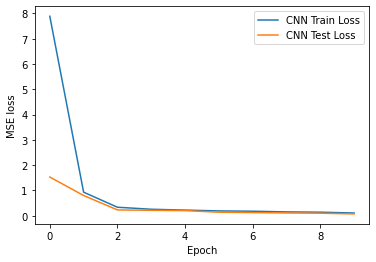

In [37]:
seq_len = len(train_df['seq'][0])
multi_cnn_model = DNA_CNN_Multi(seq_len)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_cnn_model.parameters(), lr=0.01) 

epochs = 10
train_dl,test_dl = dls['multi_ohe']
train_losses_cnn, val_losses_cnn = fit(epochs, multi_cnn_model, loss_func, optimizer, train_dl, test_dl)

multi_cnn_data_label = list(zip([train_losses_cnn,val_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(multi_cnn_data_label)

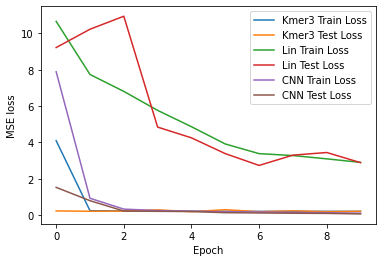

In [38]:
u.quick_loss_plot(kmer_lin_data_label + multi_lin_data_label + multi_cnn_data_label)

In [39]:
quick_test8(multi_cnn_model, DatasetSpec('multi_ohe'), multi_8mer_oracle)

AAAAAAAA: 
 	pred:19.929 act:20.000 (0.071) 
	pred:20.023 act:20.000 (-0.023) 
	pred:19.861 act:20.000 (0.139)
CCCCCCCC: 
 	pred:16.972 act:17.000 (0.028) 
	pred:17.099 act:17.000 (-0.099) 
	pred:16.828 act:17.000 (0.172)
GGGGGGGG: 
 	pred:14.013 act:14.000 (-0.013) 
	pred:14.122 act:14.000 (-0.122) 
	pred:13.969 act:14.000 (0.031)
TTTTTTTT: 
 	pred:11.082 act:11.000 (-0.082) 
	pred:11.178 act:11.000 (-0.178) 
	pred:10.869 act:11.000 (0.131)

AACCAACA: 
 	pred:18.782 act:18.875 (0.093) 
	pred:18.873 act:18.875 (0.002) 
	pred:18.766 act:18.875 (0.109)
CCGGCGCG: 
 	pred:15.335 act:15.500 (0.165) 
	pred:2.875 act:5.500 (2.625) 
	pred:27.917 act:25.500 (-2.417)
GGGTAAGG: 
 	pred:15.116 act:15.125 (0.009) 
	pred:15.258 act:15.125 (-0.133) 
	pred:14.917 act:15.125 (0.208)
TTTCGTTT: 
 	pred:12.170 act:12.125 (-0.045) 
	pred:12.235 act:12.125 (-0.110) 
	pred:12.026 act:12.125 (0.099)
TGTAATAC: 
 	pred:15.418 act:15.500 (0.082) 
	pred:15.548 act:15.500 (-0.048) 
	pred:15.285 act:15.500 (0.215)


In [61]:
def alt_parity_plot_multi(model,df, pearson,task):
    chart = alt.Chart(df).mark_circle(opacity=0.2).encode(
        alt.X('pred:Q'),
        alt.Y('truth:Q'),
        alt.Color('mode:N'),
        tooltip=['seq:N']
    ).properties(
        title=f'Model (pearson:{pearson})'
    ).interactive()
    
    chart.save(f'alt_out/parity_plot_{task}_{model}.html')
    
def parity_plot_multi(model,df, pearson):
    #plt.scatter(df['pred'].values, df['truth'].values, alpha=0.2)
    sns.scatterplot(data=df,x='pred',y='truth',hue='mode',alpha=0.2)
    plt.xlabel("Predicted Score",fontsize=14)
    plt.ylabel("Actual Score",fontsize=14)
    plt.title(f"{model} (pearson:{pearson:.3f})",fontsize=20)
    plt.show()

def parity_pred_multi(models, seqs, oracle,task,alt=False):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model,dss in models:
        print(f"Running {model_name}")
        data = []
        for dna in seqs:
            if dss.name == "multi_ohe":
                s = torch.tensor(u.one_hot_encode(dna))
            elif dss.name == "multi_kmer":
                s = torch.tensor(count_kmers_in_seq(dna,kmers(dss.k)))
            else:
                raise ValueError(f"Unknown DataSetSpec Type {dss.name}. Currently just [multi_ohe,multi_kmer]")
        
            #s = torch.tensor(u.one_hot_encode(dna))
            actual = oracle[dna]
            pred = [x.item() for x in model(s.float())]
            
            
            # loop through each prediction task
            for i in range(len(actual)):
                actual_i = actual[i]
                pred_i = pred[i]
                mode = f'mode{i}'
                data.append([dna,actual_i,pred_i,mode])
                
        df = pd.DataFrame(data, columns=['seq','truth','pred','mode'])
        pearson = df['truth'].corr(df['pred'])
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            alt_parity_plot_multi(model_name, df, pearson,task)
            
        parity_plot_multi(model_name, df, pearson)

    return dfs

In [62]:
import seaborn as sns

Running Multi_Linear_8mer


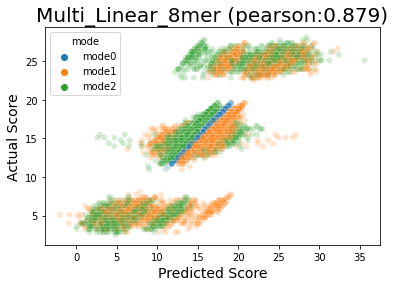

Running Multi_Kmer_8mer


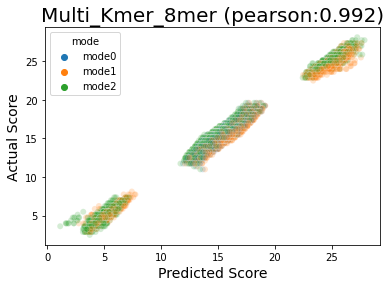

Running Multi_CNN_8mer


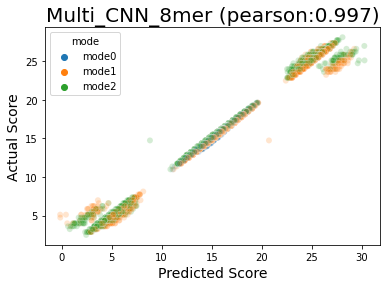

In [63]:
models = [
    ("Multi_Linear_8mer",multi_lin_model,DatasetSpec('multi_ohe')),
    ("Multi_Kmer_8mer",kmer_lin_model,DatasetSpec('multi_kmer',k=3)),
    ("Multi_CNN_8mer",multi_cnn_model,DatasetSpec('multi_ohe')),
]

seqs = test_df['seq'].values
task = "8mer_multitask"

dfs = parity_pred_multi(models, seqs, multi_8mer_oracle,task,alt=True)

In [52]:
import altair as alt

# inspect

### cnn model

In [40]:
multi_cnn_model

DNA_CNN_Multi(
  (conv_share): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=192, out_features=10, bias=True)
    (4): ReLU(inplace=True)
  )
  (obj0): Linear(in_features=10, out_features=1, bias=True)
  (obj1): Linear(in_features=10, out_features=1, bias=True)
  (obj2): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
conv_layers, model_weights, bias_weights = u.get_conv_layers_from_model(multi_cnn_model)

Total convolutional layers: 1


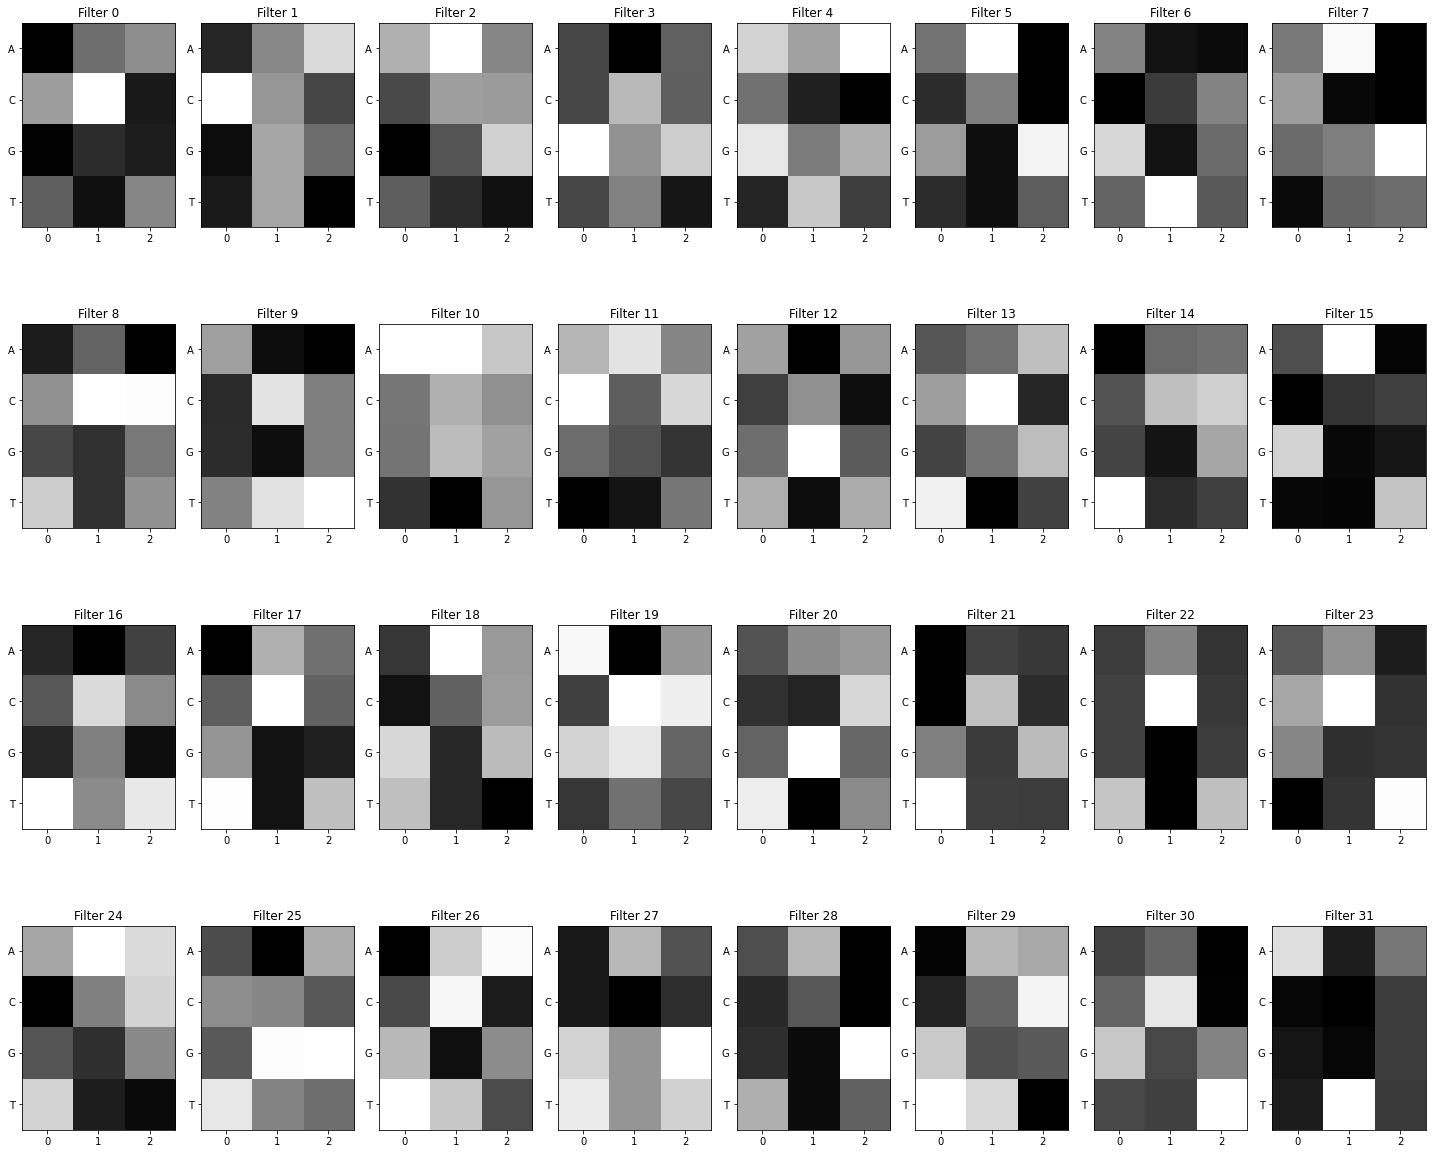

In [42]:
u.view_filters(model_weights)

In [43]:
seqs8_5k = u.downselect_list(seqs8,5000)
filter_activations = u.get_filter_activations(seqs8_5k, conv_layers[0])

Running seq AGGTCGGA
Running seq AAAAACAG
Running seq TTGTGGAG
Running seq AGCTAGGC
Running seq AACTTATA
Running seq GGCAGCCC
Running seq TTAGCCTA
Running seq GCAACGCC
Running seq ATGTCTGT
Running seq CGGCACGT
Running seq CGCCTTAC
Running seq GTAAATAA
Running seq TTGGGGCA
Running seq TAAGCAGA
Running seq GGCATCAA
Running seq GACGACAG
Running seq AATACCTA
Running seq GCGTTCGT
Running seq AGCGTACC
Running seq TGCGTCAA
Running seq AAACCTTG
Running seq TCAGCGAG
Running seq AGCAAGGT
Running seq GTATCCCA
Running seq CTAACTAA
Running seq AACAAACC
Running seq AGCGCCCA
Running seq GCTCCGTA
Running seq ACAGGCGA
Running seq TCCTGAGC
Running seq GAGTAGTG
Running seq AACCTTTA
Running seq GGGTTCCG
Running seq GGTACTGC
Running seq AGCCTTTT
Running seq TCCTCACT
Running seq CTCGCCAT
Running seq ACGTATCG
Running seq TCGGCTAT
Running seq CGGATGAT
Running seq CGCTCCGA
Running seq AAATGTCA
Running seq AAGGTTTC
Running seq GAGGAGCT
Running seq TCCCATAT
Running seq CATCTTGA
Running seq TGCGGAAG
Running seq A

Running seq AGAGGTAG
Running seq CTACATCA
Running seq GTGACATA
Running seq TGACTATC
Running seq ATCTTCTC
Running seq CTGGCGCG
Running seq GTGTCCGC
Running seq AGATGCGC
Running seq CTAGTATC
Running seq GTCTTCGG
Running seq ATCTTAGC
Running seq CCCCTATC
Running seq CACCTATG
Running seq GGTCATGC
Running seq CGCTAGAT
Running seq GACTGCGG
Running seq GGTGCTGT
Running seq GCTTTTCA
Running seq CGCCCCAA
Running seq TGATGTGC
Running seq GACACATA
Running seq TCCGATGT
Running seq TGTGGGGG
Running seq TTGCGTAC
Running seq GGGGAATA
Running seq CCTGGAAT
Running seq GGCTCAAA
Running seq GATTGCAT
Running seq CTTAGGTG
Running seq CGGCAAAT
Running seq CTGAAAAT
Running seq TAGCAGAT
Running seq CCGTCGCG
Running seq GTTACGTC
Running seq CTTTCAAA
Running seq GCCGGTAA
Running seq TAAGGGAC
Running seq AAAGCTCG
Running seq CGCTTCCC
Running seq AGCATGGA
Running seq CTATTAGG
Running seq GGCCAAGA
Running seq CACGGACT
Running seq ATCGTCTA
Running seq GGGCCTGT
Running seq CCGGATCG
Running seq AGTCGAGC
Running seq C

Running seq CACCGGTA
Running seq TACAACCG
Running seq ACGAGACG
Running seq TCTGCGCC
Running seq GCTGCTAG
Running seq TTCCCGTG
Running seq ACATTGAG
Running seq TTACTTGC
Running seq CGTGCTGA
Running seq AGAACGTT
Running seq ATGGTGAC
Running seq CGTCTGCC
Running seq ATACCAGA
Running seq CGGCACTG
Running seq GAACAGTT
Running seq GACATTAA
Running seq GTGAGAAT
Running seq ACTGGGCT
Running seq GCCAGCTG
Running seq GCCCGTGT
Running seq GAGCCCCG
Running seq CAATCGGC
Running seq GTTGGTTA
Running seq GAGTGAGG
Running seq AGAGTATG
Running seq TCGGCGCC
Running seq GAGGTCTC
Running seq AGAGGTAT
Running seq CCCATACA
Running seq TTCCGTCC
Running seq TGGGGCCA
Running seq GATTTAGA
Running seq GTCGACAT
Running seq CCCTCATC
Running seq TGATGCAT
Running seq AAGTGCTT
Running seq CTACTGGG
Running seq AACGAGGT
Running seq GAAGCTGG
Running seq CTTTTCGC
Running seq AGAGGTGT
Running seq GTGCCCTA
Running seq GAATGTTT
Running seq CCTTCGAA
Running seq TACTGCAT
Running seq GCCCACAC
Running seq CGAGCGTG
Running seq G

Running seq GCTTGGAG
Running seq AAGCAATC
Running seq GGGAGCCG
Running seq ATCATTAA
Running seq TAGCTCGG
Running seq GAACAGAG
Running seq AGTCTGGC
Running seq TAAACTGG
Running seq GACAAGGA
Running seq CGAGCTGA
Running seq CCACTTGA
Running seq TGTGTCAG
Running seq CAAGCAGC
Running seq CTGGAAGC
Running seq GCACACTT
Running seq TAAGTTGG
Running seq ACTGCCGT
Running seq GTCAAGCG
Running seq GCGTTCCC
Running seq AGCCTTCA
Running seq GGCAGTAA
Running seq TTCGCGGA
Running seq ACTCCGGA
Running seq TTTTCCCG
Running seq GAAGATTG
Running seq GCCAGGAG
Running seq ATGAATAC
Running seq TCGGAACC
Running seq CGTGGTTA
Running seq AACCTATG
Running seq GGTGGGTG
Running seq CCCACTTC
Running seq TTGATCCC
Running seq TCAGAGAG
Running seq ATGAATTC
Running seq CACCTGCC
Running seq CCCTGTCT
Running seq CACGGATA
Running seq AAAGGCCC
Running seq ACGGATGT
Running seq TTGTTCGA
Running seq CCCCACTG
Running seq TATATAAG
Running seq TCCAACCC
Running seq TCCCAGAC
Running seq TCGTAGAA
Running seq TTGCAGAC
Running seq C

Running seq TTTCAGGG
Running seq AGCGAAAG
Running seq GGGCGCTC
Running seq GAGAAGCT
Running seq GGATCCGA
Running seq CGGACCAT
Running seq GTGCGACG
Running seq AAGAACGT
Running seq CTCATACT
Running seq ACGCGGCT
Running seq CTCCTGCG
Running seq TGTTATTT
Running seq CCGCACAG
Running seq TAGTCCGC
Running seq CTACCGTG
Running seq CCAATGTA
Running seq CGGGCACG
Running seq ACCTTCTG
Running seq ATAGGAGT
Running seq CGCGATGA
Running seq ATGGCCGG
Running seq ACCCTCTT
Running seq ACAATTAA
Running seq CAACTAGC
Running seq CGTAGGCC
Running seq GTTCTGTT
Running seq ATAGTCCG
Running seq CGTTGGTA
Running seq TTGCTGTT
Running seq CCCCCACT
Running seq AGGCCTCC
Running seq CACCCTGA
Running seq ACCACTAT
Running seq GGTGACCT
Running seq GGATGTAT
Running seq CAACTGGG
Running seq AACTATAA
Running seq GACTACCC
Running seq GCATGCAA
Running seq CCGTCCCG
Running seq TGATGAGG
Running seq ACTAGCAA
Running seq TTCCTGCG
Running seq CGAAACTG
Running seq CCCAGGTG
Running seq GAGGAAGC
Running seq GTCATAGC
Running seq C

Running seq ACCACTCT
Running seq CTTTAGGC
Running seq TGCTTCAG
Running seq CCGCGGTT
Running seq TCAAACGG
Running seq CGAAGCTG
Running seq ATATAACC
Running seq AGGTCAAA
Running seq CATGGGGT
Running seq CACCGATT
Running seq ATGTACAC
Running seq CGACCTTG
Running seq TGATTCTG
Running seq GCATAAAC
Running seq GCCATTAG
Running seq GGGGTGCG
Running seq TAAGCAGG
Running seq CTCATGAA
Running seq GTAGGCGT
Running seq TCCTACAT
Running seq CCAGAATG
Running seq CGAACGGA
Running seq AGGTAGCT
Running seq TGAGATTG
Running seq GCAAGAAG
Running seq GACAATTC
Running seq AGGGTTAG
Running seq ACTATAGT
Running seq GTACGTTC
Running seq AGACTTGT
Running seq AAACTGTA
Running seq CACCAGGC
Running seq GATCGCCG
Running seq AGGGCATC
Running seq ACGTCGCT
Running seq CATACGTC
Running seq TCTTTGAC
Running seq AGGAGATG
Running seq TTACGATA
Running seq GGGTGGAA
Running seq ACGGGAGA
Running seq GAAGTGCC
Running seq ACATGAGA
Running seq TTTATGCG
Running seq GGACCGTT
Running seq ATGTCGAG
Running seq ATTTAGAA
Running seq T

Running seq CGACATCA
Running seq TCTGCAGT
Running seq GCTGATTC
Running seq CTTCTACG
Running seq TTGCAATA
Running seq TTATAGCC
Running seq GCTTACTA
Running seq GAATGTGA
Running seq ACCAGCGG
Running seq AGAAAAGC
Running seq AATCCGGT
Running seq CTTTACTG
Running seq CGACCATG
Running seq GTTAGCAT
Running seq CAGTCCCC
Running seq CCTGTTAC
Running seq ACGGCAGT
Running seq TGTAGTGT
Running seq GGTGACTC
Running seq CATTAGCC
Running seq CTTCCGCT
Running seq TAATTCTC
Running seq TATAACAT
Running seq CCTCCGCA
Running seq GGTCCCCA
Running seq AACGAATG
Running seq AGATTAAT
Running seq GCTTCCTT
Running seq ATCCAAGT
Running seq ATTGATGC
Running seq GCTACTCT
Running seq ACCCATAT
Running seq GCGGAGTT
Running seq TCAGTCAT
Running seq ACGCATTT
Running seq AATCACCC
Running seq TGTATAAG
Running seq ACAGTCTT
Running seq GGCACGGA
Running seq TGGTGTCA
Running seq ACATTTGC
Running seq ATACGACC
Running seq GCGGTGTC
Running seq CACGCAGT
Running seq CATAACTT
Running seq CATTAGAC
Running seq TGCACTAG
Running seq C

Running seq GATGCTGA
Running seq ACGACCCG
Running seq CGGCTCCA
Running seq TGCGATGA
Running seq GCACATGT
Running seq AACTGTCG
Running seq CCTGCACA
Running seq ACCCAAGT
Running seq CCGACCCA
Running seq CCCGCACT
Running seq ATTTGGGG
Running seq GTAAGAGA
Running seq ACTCCCCT
Running seq ACTGAACT
Running seq TAAGTACT
Running seq TAACAGTG
Running seq ATTTCCGT
Running seq CATGACCC
Running seq CAACCCCG
Running seq TCACCCTT
Running seq GGGTAACT
Running seq CCGAATGA
Running seq ACGCGGGT
Running seq CCGAAAAG
Running seq TTCGCCTA
Running seq AAAAGACG
Running seq TTGCCGTG
Running seq GCGACGAG
Running seq GCCACACA
Running seq CCACTGGT
Running seq GTACGTGC
Running seq AGCTAATA
Running seq CAGCTTAC
Running seq CCGGTCAA
Running seq GATACAAC
Running seq ACCTCATG
Running seq GCTCCGGA
Running seq ACGCCTCG
Running seq AAGCCCGG
Running seq ATGACATC
Running seq ATTACTAA
Running seq GTGCATTG
Running seq CAAATGGC
Running seq CTATGTAG
Running seq TTGAACTC
Running seq CGGTTGTC
Running seq GCGCACGC
Running seq C

Running seq TAATATGC
Running seq GCCACCCT
Running seq TGCTACGA
Running seq AACGTTCA
Running seq GCAGAGCA
Running seq GATCACAT
Running seq CATTCTGA
Running seq CATCATTG
Running seq CATAGCTC
Running seq TACAAGCT
Running seq AGTAGCGA
Running seq CAACCGTT
Running seq CCACACAT
Running seq GTACTGGT
Running seq GGCACACA
Running seq TTCTAATC
Running seq TTGAGACG
Running seq ACTAAGAA
Running seq ATTGCTAT
Running seq GACCTTAT
Running seq CCCAAATA
Running seq CCCTCCCT
Running seq CCCGTTGG
Running seq CGATGTTG
Running seq GCACCTCA
Running seq TAGTCGGT
Running seq CTCAAAAT
Running seq ATGTATAT
Running seq GGACCAGA
Running seq ATGATAGA
Running seq CGATGATG
Running seq GCAACCCT
Running seq TGGCATGT
Running seq GTCTATAT
Running seq TGCCTGTA
Running seq ATATCCAC
Running seq TTCTCCCT
Running seq AGAGTCCA
Running seq TGCCCAGA
Running seq TATCCGGG
Running seq TGCGCCGG
Running seq AGATCAAA
Running seq CGGACAAA
Running seq ACTTGTCC
Running seq GAGGGGAG
Running seq GGATCTTG
Running seq GATCAGCT
Running seq A

Running seq GGCCGGAT
Running seq CTACCATT
Running seq GTGTGTCC
Running seq AGATTTGA
Running seq CACCCCTT
Running seq GGTTTGCG
Running seq CTTTGACA
Running seq TCCATGAG
Running seq TTTCGGAG
Running seq CACATAAA
Running seq ATTGCATA
Running seq TAGCACAA
Running seq CTACTAAG
Running seq CTCTACAA
Running seq CCCTCCTT
Running seq TATTCCTA
Running seq TTACTTGA
Running seq AGATCGGC
Running seq GACATGTC
Running seq GTCACGCC
Running seq AGCAGACC
Running seq GGTGGTTC
Running seq AACAAAAT
Running seq AAGGGAGA
Running seq ACTTGGGT
Running seq TGCCGTAC
Running seq ATGACAAC
Running seq GCGTACTG
Running seq ACAGCTGT
Running seq AACCAGGC
Running seq GCAAGAAA
Running seq GAACTACG
Running seq AGATCCAT
Running seq TTTTGGCC
Running seq TCGCCCTA
Running seq GTACGCAG
Running seq TCGTGGGC
Running seq TCCATGTT
Running seq GACCGCTT
Running seq CACGGGGG
Running seq TCATCATA
Running seq GCGACGCT
Running seq CGGATTTG
Running seq CCTACAGA
Running seq ATGCTGCG
Running seq CTAGGAGA
Running seq GCGGTTAT
Running seq A

Running seq GGGCTTTA
Running seq AGATGAAG
Running seq GTAATGGC
Running seq ATAGGGGG
Running seq ATGGGCGC
Running seq TGATGTAT
Running seq TGACGCAT
Running seq GATTGATA
Running seq TCTTGTTC
Running seq AATGTGCT
Running seq GACACTTC
Running seq TTAGCGTG
Running seq TCCAGAGT
Running seq CAGAAGGT
Running seq CCTACTGA
Running seq CTCCCACG
Running seq TTATGCCC
Running seq CCCGCGAC
Running seq ACCCAGTT
Running seq GGGCAGAG
Running seq GCGGAGTC
Running seq GACAACTG
Running seq AGGTGCCG
Running seq GCGAGCTG
Running seq GCGAGAAT
Running seq ATCTCAAG
Running seq GATCTCAC
Running seq CAGCCGAC
Running seq AAAGACTT
Running seq CCTTGCGA
Running seq ATCCATAT
Running seq GCTAATTG
Running seq TCTTGAGC
Running seq GGAGGGCA
Running seq CAGGCCAT
Running seq GCCTCATC
Running seq CCAAGATT
Running seq ATCCCTCC
Running seq CAGTGACT
Running seq TGTAATAG
Running seq TCGTTGCT
Running seq GGAAGGCC
Running seq CTCCCTCC
Running seq CGGCATCC
Running seq TGTTGCCG
Running seq GGTTTCAG
Running seq CGCAATTA
Running seq T

Running seq AGACCTAA
Running seq AGCTCAAG
Running seq GATCAAAC
Running seq TCCGAAAC
Running seq CATAATTT
Running seq GGGTATAA
Running seq GAATGACC
Running seq AGAAACAG
Running seq AGATGCGA
Running seq AAATCGGG
Running seq GTCCAGTC
Running seq ATTGTTGC
Running seq AGTGCAGG
Running seq ACCCGGCG
Running seq CGTCTGGT
Running seq ATGTGCAT
Running seq GTTCTATG
Running seq CAGGTTCA
Running seq AAAAGGCC
Running seq GTCCACGA
Running seq CAACCTAC
Running seq ATTCACAA
Running seq GTTATCCA
Running seq GTAAAGTT
Running seq TCTGCTGG
Running seq CGATAAAC
Running seq GCTGCGCC
Running seq ATATGCGG
Running seq TAAGCAAG
Running seq CTTGCGGT
Running seq TCCCGATA
Running seq CCTGTTCA
Running seq GAGTCCAG
Running seq CACTTATC
Running seq GCGTGCTG
Running seq ATGAACAG
Running seq TAATCCGA
Running seq TTCCCCGC
Running seq TGAGCAGT
Running seq ATATTTGT
Running seq TCAACACG
Running seq TGGAACTA
Running seq ATACAGGG
Running seq CGTGAGAG
Running seq GGTCTCCG
Running seq TAATACAT
Running seq AGGTAGTT
Running seq C

Running seq TACGTGAT
Running seq TACTATAC
Running seq CTTCTGTT
Running seq CACCGTAC
Running seq CAGTTTTC
Running seq CCGGATCC
Running seq ATGTACCA
Running seq GGGATGTG
Running seq TTAACGGC
Running seq GTGACCCG
Running seq GTTTCGTC
Running seq CACCCACT
Running seq GTTGTTCA
Running seq GATTGATT
Running seq AGTGCCGC
Running seq CGTAGGTG
Running seq GCAGCATA
Running seq GTCTGGGC
Running seq TGATCCCA
Running seq TCCAGTTA
Running seq GTAGAGCC
Running seq CCTACATA
Running seq GTCAAGTC
Running seq GAGCCCAC
Running seq TCTTCCCA
Running seq CGCCCTTC
Running seq GGTTGATT
Running seq AACATCTC
Running seq CGGATAAA
Running seq GAGCGTAG
Running seq GGTCTAAG
Running seq GGTGGCAA
Running seq CAAAGGAA
Running seq CCGTTCCG
Running seq GACCAAGG
Running seq CCCTAGTG
Running seq ATTGGGCA
Running seq TTGTCGAA
Running seq AATCTCGG
Running seq AAACAGCG
Running seq GTCAAAGG
Running seq CAGCGCCT
Running seq TGGGGAAT
Running seq ACTTGGAG
Running seq ACTACAGC
Running seq TGGGTGCG
Running seq TGGATGTG
Running seq G

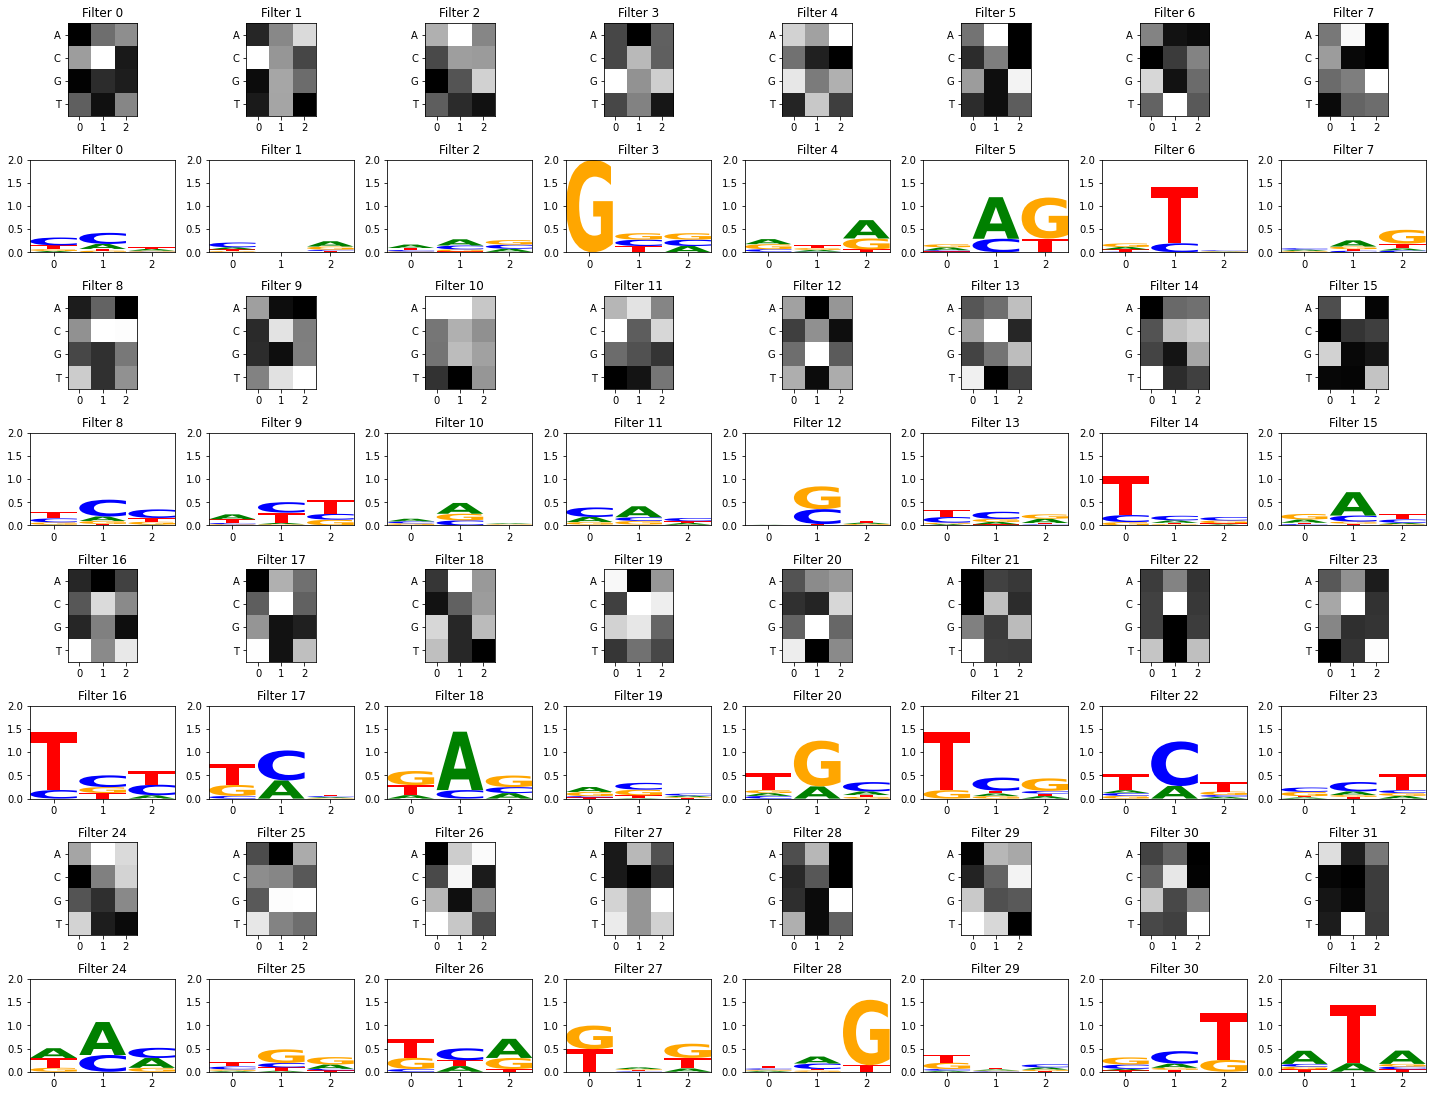

In [44]:
u.view_filters_and_logos(model_weights,filter_activations)

# Try LSTM multi

In [64]:
class DNA_LSTM_Multi(nn.Module):
    def __init__(self,seq_len,hidden_dim=10):
        super().__init__()
        self.seq_len = seq_len

        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
        #self.fc = nn.Linear(hidden_dim, 1)
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(hidden_dim,1)
        self.obj1  = nn.Linear(hidden_dim,1)
        self.obj2  = nn.Linear(hidden_dim,1)
            

    
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

    def forward(self, xb,verbose=False):
        if verbose:
            print("original xb.shape:", xb.shape)
            print(xb) # 11 x 32
        
        # make the one-hot nucleotide vectors group together
        xb = xb.view(-1,self.seq_len,4) 
        if verbose:
            print("re-viewed xb.shape:", xb.shape) # >> 11 x 8 x 4
            print(xb)

        # ** Init hidden/cell states?? **
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
         
        # *******
        
        lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
        if verbose:
            #print("lstm_out",lstm_out)
            print("lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
            print("lstm_out[-1] shape:",lstm_out[-1].shape) # >> 8 x 10
            print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape) # 10

            print("hidden len:",len(self.hidden)) # 2
            print("hidden[0] shape:", self.hidden[0].shape) # >> 1 x 11 x 10
            print("hidden[0][-1] shape:", self.hidden[0][-1].shape) # >> 11 X 10
            print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape) # >> 10

            print("*****")
            # These vectors should be the same, right?
            A = lstm_out[-1][-1]
            B = self.hidden[0][-1][-1]
            print("lstm_out[-1][-1]:",A)
            print("self.hidden[0][-1][-1]",B)
            print("==?", A==B)
            print("*****")
                        
        # attempt to get the last layer from each last position of 
        # all seqs in the batch? IS this the right thing to get?
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        #last_layer = lstm_out[-1][-1].unsqueeze(0) # this was [10X1]? led to FC outoput being [1]?

        out0 = self.obj0(last_layer)
        out1 = self.obj1(last_layer)
        out2 = self.obj2(last_layer)
        
        if verbose:
            print("last layer:", last_layer.shape)
            print("LSTM->FC out shape:",out0.shape)   
                                                
        return out0,out1,out2

Epoch: 0
0 9.654402640013569
Epoch: 1
1 9.236358354322277
Epoch: 2
2 8.553090200578435
Epoch: 3
3 7.24061224087368
Epoch: 4
4 4.703378122719388
Epoch: 5
5 1.7489032485625495
Epoch: 6
6 0.7675790344755716
Epoch: 7
7 0.6291534997247725
Epoch: 8
8 0.4566819995214272
Epoch: 9
9 2.2142773611464803


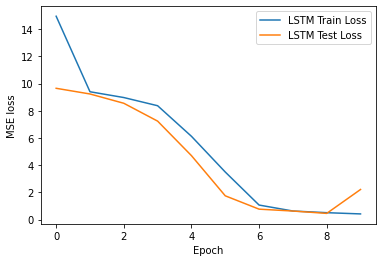

In [65]:
seq_len = len(train_df['seq'][0])
multi_lstm_model = DNA_LSTM_Multi(seq_len)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_lstm_model.parameters(), lr=0.01) 

epochs = 10
train_dl,test_dl = dls['multi_ohe']
train_losses_lstm, val_losses_lstm = fit(epochs, multi_lstm_model, loss_func, optimizer, train_dl, test_dl)

multi_lstm_data_label = list(zip([train_losses_lstm,val_losses_lstm], ['LSTM Train Loss','LSTM Test Loss']))
u.quick_loss_plot(multi_lstm_data_label)

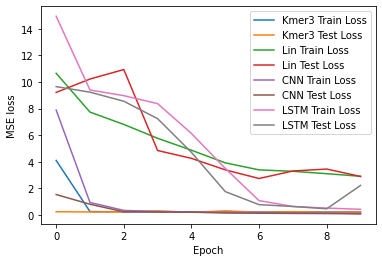

In [66]:
u.quick_loss_plot(
    kmer_lin_data_label + \
    multi_lin_data_label + \
    multi_cnn_data_label + \
    multi_lstm_data_label
)

Running Multi_Linear_8mer


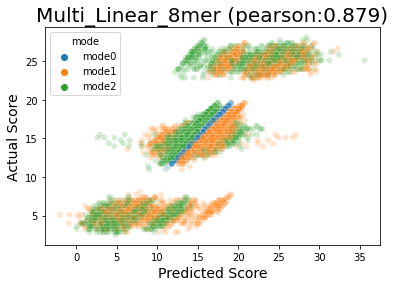

Running Multi_Kmer_8mer


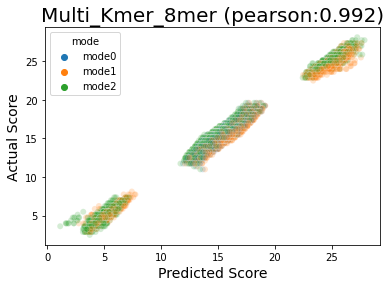

Running Multi_CNN_8mer


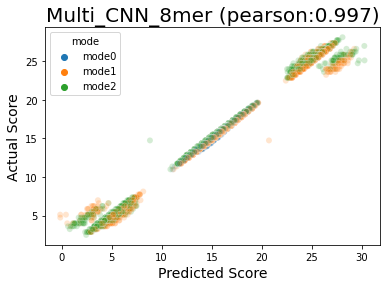

Running Multi_LSTM_8mer


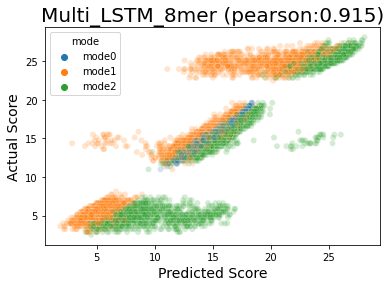

In [67]:
models = [
    ("Multi_Linear_8mer",multi_lin_model,DatasetSpec('multi_ohe')),
    ("Multi_Kmer_8mer",kmer_lin_model,DatasetSpec('multi_kmer',k=3)),
    ("Multi_CNN_8mer",multi_cnn_model,DatasetSpec('multi_ohe')),
    ("Multi_LSTM_8mer",multi_lstm_model,DatasetSpec('multi_ohe')),
]

seqs = test_df['seq'].values
task = "8mer_multitask"

dfs = parity_pred_multi(models, seqs, multi_8mer_oracle,task,alt=True)